In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import src.utils as utils

#### Load the graph data

In [45]:
# Load the total repeatsdb dataframe
rdb_total_df = pd.read_csv("../data/repeatsdb_supplemented_updated.csv", dtype={"ct": str})
rdb_total_df

,region_id,uniprot,ctfc,units,units_num,units_avg,insertions,insertions_num,pdb,ct
0,4zb5A_11_311,P24300,4.5.0.0,"11_49,50_87,88_132,133_176,177_211,212_244,245...",8,36.62,NaN,0,4zb5A,4.5
1,5zbgA_24_171,Q13507,3.3.0,"24_53,54_87,88_116,117_171",4,36.00,121_149,1,5zbgA,3.3
2,2zb5A_215_606,P08362,4.4.0.0,"215_285,286_345,346_441,442_482,509_561,562_606",6,60.00,"372_408,483_508",2,2zb5A,4.4
3,4zb4A_188_502,P32523,4.4.0.0,"188_247,248_287,288_334,335_376,377_423,424_47...",7,44.00,NaN,0,4zb4A,4.4
4,4zb2A_11_311,P24300,4.5.0.0,"11_49,50_84,85_132,133_176,177_211,212_244,245...",8,36.62,NaN,0,4zb2A,4.5
...,...,...,...,...,...,...,...,...,...,...
9528,3ltpA_15_225,O26232,4.1.0.0,"15_38,39_65,66_92,93_118,119_151,152_173,174_1...",8,25.38,NaN,0,3ltpA,4.1
9529,3ltsB_15_221,O26232,4.1.0.0,"15_38,39_65,66_92,93_118,119_151,152_173,174_1...",8,24.88,NaN,0,3ltsB,4.1
9530,5ltdA_33_524,Q5QA94,4.4.1,"33_72,73_120,121_159,160_224,225_269,270_452,4...",7,69.29,462_489,1,5ltdA,4.4
9531,3ltyB_15_222,O26232,4.1.0.0,"15_38,39_65,66_92,93_118,119_151,152_173,174_1...",8,25.00,NaN,0,3ltyB,4.1


In [46]:
# Load the dataframe of unique entries in repeatsdb
rdb_unique_df = pd.read_csv("../data/repeatsdb_unique_updated.csv", dtype={'ct': str})
rdb_unique_df

,region_id,uniprot,ctfc,units,units_num,units_avg,insertions,insertions_num,pdb,ct
0,4zb5A_11_311,P24300,4.5.0.0,"11_49,50_87,88_132,133_176,177_211,212_244,245...",8,36.62,NaN,0,4zb5A,4.5
1,5zbgA_24_171,Q13507,3.3.0,"24_53,54_87,88_116,117_171",4,36.00,121_149,1,5zbgA,3.3
2,2zb5A_215_606,P08362,4.4.0.0,"215_285,286_345,346_441,442_482,509_561,562_606",6,60.00,"372_408,483_508",2,2zb5A,4.4
3,4zb4A_188_502,P32523,4.4.0.0,"188_247,248_287,288_334,335_376,377_423,424_47...",7,44.00,NaN,0,4zb4A,4.4
4,2zb1A_8_108,Q16539,4.2.0,"8_23,24_47,88_108",3,19.33,48_87,1,2zb1A,4.2
...,...,...,...,...,...,...,...,...,...,...
2468,3ctlA_2_218,P32719,4.1.1.3,"2_27,28_59,60_81,82_107,108_129,130_167,168_18...",8,26.12,NaN,0,3ctlA,4.1
2469,5ctrA_307_586,Q15020,3.3.0.0,"307_341,342_376,377_411,412_469,470_506,507_53...",7,39.00,NaN,0,5ctrA,3.3
2470,5ltpA_6_215,A0A1S4NYF2,4.2.0,"6_31,32_94,95_127,148_179,190_215",5,35.00,"45_82,128_147,180_189",3,5ltpA,4.2
2471,5ltdA_33_524,Q5QA94,4.4.1,"33_72,73_120,121_159,160_224,225_269,270_452,4...",7,69.29,462_489,1,5ltdA,4.4


In [47]:
# Load the graph data of an region_id from rdb_unique_df
region_id = "4h09E_55_392"
graph_dir = "/home/soroushm/Documents/ML-TRP-Parser_workframe/dataframes/graph_tmscore_output"
graph_path = os.path.join(graph_dir, f"{region_id[1:3]}", f"{region_id}_vs_{region_id}_graph.csv")
graph_df = pd.read_csv(graph_path)
graph_df

,x_start,x_end,y
0,33,55,0.12115
1,34,56,0.16296
2,35,57,0.16296
3,36,58,0.15090
4,37,59,0.11542
...,...,...,...
352,385,407,0.19780
353,386,408,0.14852
354,387,409,0.14825
355,388,410,0.14868


In [48]:
# Create a list of region_id's with more than one entry with same pdb and class.topology (ct)
multi_region_list = rdb_total_df.groupby(['pdb', 'ct']).filter(lambda group: len(group) > 1)["region_id"].tolist()

# If the instance region_id in multi_region_list, limit the graph data to the region_id start and end positions
if region_id in multi_region_list:
    region_start = int(region_id.split("_")[1])
    region_end = int(region_id.split("_")[2])
    graph_df = graph_df[region_start <= graph_df["x_start"]]
    graph_df = graph_df[region_end >= graph_df["x_start"]]

#### Visualize the graph

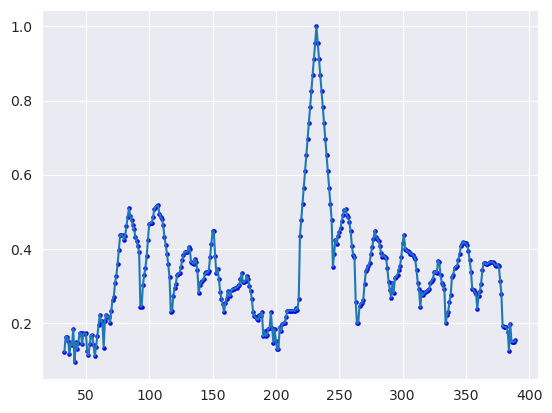

In [49]:
x = np.array(graph_df["x_start"])
y = np.array(graph_df["y"])

# Plot the results
# Create a figure and axis
fig, ax = plt.subplots(dpi=100)
# Graph of all the residue vs tm-score points
ax.plot(x, y)
# Scatter of all the residue vs tm-score points
ax.scatter(x, y, marker='o', color='blue', s=5)

plt.show()

#### Smooth the graph

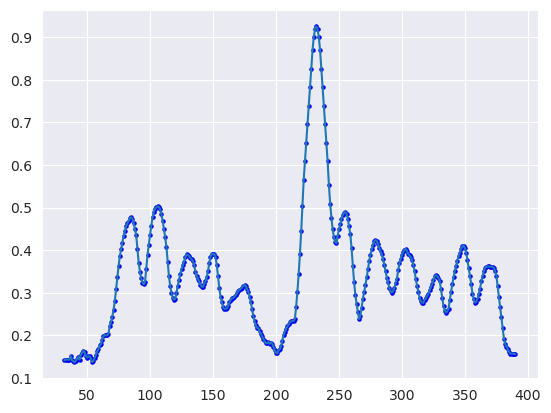

In [50]:
window_len = graph_df.iloc[0, 1] - graph_df.iloc[0, 0] + 1  # Last residue is inclusive
# Smooth the graph by n residue window size (small size --> noise reduction & not compromising resolution)
smooth_window_size = round(window_len * 0.33)
if smooth_window_size % 2 == 0:
    smooth_window_size -= 1
poly_order = 0
y = savgol_filter(y, smooth_window_size, poly_order)

x, y = utils.adjust_graph_ends(x, y)

# Plot the results
# Create a figure and axis
fig, ax = plt.subplots(dpi=100)
# Graph of all the residue vs tm-score points
ax.plot(x, y)
# Scatter of all the residue vs tm-score points
ax.scatter(x, y, marker='o', color='blue', s=5)

plt.show()

#### Detect the peaks

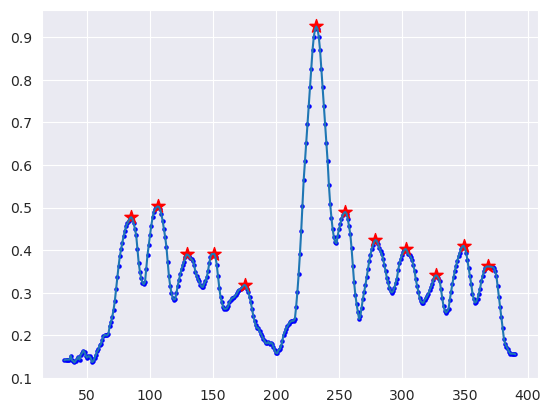

In [51]:
# Detect peaks and associated properties
peaks, properties = find_peaks(y, height=0.3, distance=round(window_len * 0.6),
                      threshold=0, prominence=0.01, width=0)

# Mark the peaks on y and x-axis
peaks_x = [x[peak_idx] for peak_idx in peaks]
peaks_y = [y[peak_idx] for peak_idx in peaks]

start_list = [x[peak_idx] for peak_idx in peaks]

# Plot the results
# Create a figure and axis
fig, ax = plt.subplots(dpi=100)
# Graph of all the residue vs tm-score points
ax.plot(x, y)
# Scatter of all the residue vs tm-score points
ax.scatter(x, y, marker='o', color='blue', s=5)
# Scatter of the detected peaks
ax.scatter(peaks_x, peaks_y, marker="*", color="red", s=100)

plt.show()

#### Compare the detected peaks with the reference in RepeatsDB

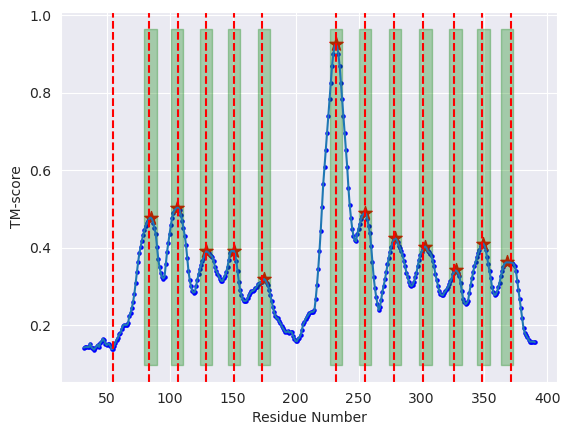

In [52]:
# Extract data of the reference units
ref_units = rdb_unique_df[rdb_unique_df["region_id"] == region_id]["units"].values[0].split(",")
ref_unit_start_list = [int(i.split("_")[0]) for i in ref_units]

# Plot the results
# Create a figure and axis
fig, ax = plt.subplots(dpi=100)
# Graph of all the residue vs tm-score points
ax.plot(x, y)
# Scatter of all the residue vs tm-score points
ax.scatter(x, y, marker='o', color='blue', s=5)
# Scatter of the detected peaks
ax.scatter(peaks_x, peaks_y, marker="*", color="red", s=100)
# Visualize the reference unit positions by vertical red lines
for ref_unit_start in ref_unit_start_list:
    ax.axvline(x=ref_unit_start, color='r', linestyle='--')
# Visualize the accepted margin of error by vertical green highlight
lim_1 = ax.get_ylim()[1]
lim_2 = ax.get_ylim()[0]
margin = round(window_len * 0.2)

for point in peaks_x:
    start_x = max(point - margin, min(x))
    end_x = min(point + margin, max(x))
    ax.fill_between([start_x, end_x], lim_1, lim_2, color='green', alpha=0.3)

ax.set_xlabel("Residue Number")
ax.set_ylabel("TM-score")
plt.show()

#### Extracted features from the detected peaks

In [53]:
properties

{'peak_heights': array([0.47747   , 0.50272143, 0.38982714, 0.39149   , 0.31852714,
        0.92546571, 0.48981857, 0.42382571, 0.40253857, 0.34075857,
        0.41015429, 0.36167714]),
 'left_thresholds': array([0.00266571, 0.00226286, 0.00681143, 0.00064571, 0.00258714,
        0.00621143, 0.00219429, 0.00313571, 0.00124857, 0.00216857,
        0.00119571, 0.00035571]),
 'right_thresholds': array([4.15428571e-03, 6.15714286e-04, 7.31428571e-04, 8.43142857e-03,
        2.60428571e-03, 6.21142857e-03, 4.02142857e-03, 2.29285714e-03,
        4.10142857e-03, 1.43142857e-03, 5.31428571e-03, 6.28571429e-05]),
 'prominences': array([0.15765857, 0.34514571, 0.07636714, 0.10770429, 0.05657857,
        0.77028571, 0.0737    , 0.18556571, 0.10216571, 0.06446429,
        0.15687714, 0.08501429]),
 'left_bases': array([  8,   8,  87,  87, 127,   8, 216, 234, 260, 285, 303, 326]),
 'right_bases': array([ 63, 169, 110, 169, 169, 358, 358, 358, 303, 303, 358, 358]),
 'widths': array([13.31183797, 19

In [54]:
# Convert the properties dict to dataframe
peaks_df = pd.DataFrame(properties)
peaks_df

,peak_heights,left_thresholds,right_thresholds,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips
0,0.477470,0.002666,0.004154,0.157659,8,63,13.311838,0.398641,44.785173,58.097011
1,0.502721,0.002263,0.000616,0.345146,8,169,19.215941,0.330149,64.169581,83.385522
2,0.389827,0.006811,0.000731,0.076367,87,110,11.182783,0.351644,92.669331,103.852114
3,0.391490,0.000646,0.008431,0.107704,87,169,8.948861,0.337638,113.093492,122.042353
4,0.318527,0.002587,0.002604,0.056579,127,169,12.023155,0.290238,135.024124,147.047278
5,0.925466,0.006211,0.006211,0.770286,8,358,20.697833,0.540323,189.596471,210.294304
6,0.489819,0.002194,0.004021,0.073700,216,358,7.826450,0.452969,218.357152,226.183602
7,0.423826,0.003136,0.002293,0.185566,234,358,16.688241,0.331043,239.718785,256.407026
8,0.402539,0.001249,0.004101,0.102166,260,303,13.051027,0.351456,264.957591,278.008618
9,0.340759,0.002169,0.001431,0.064464,285,303,8.578215,0.308526,290.404233,298.982448


In [55]:
# Create a list of reference unit accepted margin range
unit_start_range_list = []
for ref_unit_start in ref_unit_start_list:
    range_start = ref_unit_start - margin
    range_end = ref_unit_start + margin
    unit_start_range = (range_start, range_end)
    unit_start_range_list.append(unit_start_range)

# Check if the detected peaks fall into accepted margin range
peak_labels = []
for x_start in peaks_x:
    truth = 0
    for unit_start_range in unit_start_range_list:
        range_start, range_end = unit_start_range
        if range_start <= x_start <= range_end:
            truth = 1
    peak_labels.append(truth)

In [56]:
# Extract extra data regarding region_id
ct = str(rdb_total_df[rdb_total_df["region_id"] == region_id]["ct"].values[0])
window_avg = rdb_total_df[rdb_total_df["region_id"] == region_id]["units_avg"].values[0]

# Add extra data to the peaks dataframe
peaks_df["peak_x"] = peaks_x
peaks_df["ct"] = [ct for i in range(len(peaks_df))]
peaks_df["window_avg"] = [window_avg for i in range(len(peaks_df))]
peaks_df["window_len"] = [window_len for i in range(len(peaks_df))]
peaks_df["label"] = peak_labels

peaks_df

,peak_heights,left_thresholds,right_thresholds,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips,peak_x,ct,window_avg,window_len,label
0,0.477470,0.002666,0.004154,0.157659,8,63,13.311838,0.398641,44.785173,58.097011,85,3.2,25.0,23,1
1,0.502721,0.002263,0.000616,0.345146,8,169,19.215941,0.330149,64.169581,83.385522,106,3.2,25.0,23,1
2,0.389827,0.006811,0.000731,0.076367,87,110,11.182783,0.351644,92.669331,103.852114,129,3.2,25.0,23,1
3,0.391490,0.000646,0.008431,0.107704,87,169,8.948861,0.337638,113.093492,122.042353,151,3.2,25.0,23,1
4,0.318527,0.002587,0.002604,0.056579,127,169,12.023155,0.290238,135.024124,147.047278,175,3.2,25.0,23,1
5,0.925466,0.006211,0.006211,0.770286,8,358,20.697833,0.540323,189.596471,210.294304,232,3.2,25.0,23,1
6,0.489819,0.002194,0.004021,0.073700,216,358,7.826450,0.452969,218.357152,226.183602,255,3.2,25.0,23,1
7,0.423826,0.003136,0.002293,0.185566,234,358,16.688241,0.331043,239.718785,256.407026,279,3.2,25.0,23,1
8,0.402539,0.001249,0.004101,0.102166,260,303,13.051027,0.351456,264.957591,278.008618,303,3.2,25.0,23,1
9,0.340759,0.002169,0.001431,0.064464,285,303,8.578215,0.308526,290.404233,298.982448,327,3.2,25.0,23,1
